# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


In [1]:

import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tqdm import tqdm
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import math

ModuleNotFoundError: No module named 'gensim'

### Loading  and splitting of  dataset into train, cv & test dataset

In [2]:
con = sqlite3.connect('data.sqlite') 
df = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
df.shape


(103040, 12)

In [3]:
text=df['CleanedText']
label=df['Score']
from sklearn.model_selection import train_test_split
x,x_test,y,y_test=train_test_split(text,label,test_size=0.2,random_state=0, stratify=label)
x_train,x_cv,y_train,y_cv=train_test_split(x,y,test_size=0.25, random_state=0, stratify=y)
x_train.shape

(61824,)

### Conversion into BOW, TFIDF, AVG W2V & AVG TFIDF Vectorizers

In [8]:
vect=CountVectorizer(dtype="float").fit(x_train)
train_cnt=vect.transform(x_train)
cv_cnt=vect.transform(x_cv)
test_cnt=vect.transform(x_test)
idf=TfidfVectorizer().fit(x_train)
train_tf=idf.transform(x_train)
test_tf=idf.transform(x_test)
cv_tf=idf.transform(x_cv)

In [16]:
list_of_words=[]
for x in x_train.values:
    list_of_words.append(x.split())
    
w2v_model=Word2Vec(list_of_words, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

    
test_word_list=[]
for x in x_test.values:
    test_word_list.append(x.split())
    
cv_word_list=[]
for x in x_cv.values:
    cv_word_list.append(x.split())
    
train_w2v=[];
for x in tqdm(list_of_words):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v.append(sent_vec)
    
    
cv_w2v=[];
for x in tqdm(cv_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v.append(sent_vec)

test_w2v=[]
for x in tqdm(test_word_list):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v.append(sent_vec)
    

100%|███████████████████████████████████| 20608/20608 [01:00<00:00, 342.38it/s]


In [17]:
model = TfidfVectorizer()
model.fit_transform(x_train.values)

dicti= dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 

train_df= [];
row=0;
for sent in tqdm(list_of_words): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
    
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_df.append(sent_vec)
    row += 1
    
tfidf_feat = model.get_feature_names() 

test_df= []; 
row=0;
for sent in tqdm(test_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_df.append(sent_vec)
    row += 1
    
    
cv_df= []; 
row=0;
for sent in tqdm(cv_word_list):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_df.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 20608/20608 [18:44<00:00, 18.32it/s]


### Functions TO PLOT AUC vs log(C) for training vs CV , AUC plot on training and test data & to print Confusion Matrix

In [9]:
def hyperSearch(train,cv,y_train,y_cv,p):
    roc_scores=[]
    roc_t=[]
    k= [10**-4,10**-3,10**-2,10**-1, 10**0,10**1, 10**2, 10**3,10**4]
    for i in k:
        clf=LogisticRegression(C=i, penalty=p)
        clf.fit(train,y_train)
        pred=clf.predict_proba(cv)[:,1]
        pred_train=clf.predict_proba(train)[:,1]
        roc=roc_auc_score(y_cv,pred)
        roct=roc_auc_score(y_train,pred_train)
        roc_scores.append(roc)
        roc_t.append(roct)
    a=[math.log10(y) for y in k]
    plt.plot(a,roc_scores,'g--',label='CV data')
    plt.plot(a,roc_t,'r',label='Training data')
    plt.xlabel('log(C)')
    plt.ylabel('AOC Scores')
    plt.title('Error Plot')
    plt.legend()
    plt.show()



In [10]:
def rocPlot(test_data, train_data, y_train, y_test):
    pred_proba = clf.predict_proba(test_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_test, pred_proba)
    roc_auc=roc_auc_score(y_test, pred_proba)
    plt.plot(fpr, tpr, label='AUC= %0.3f for test set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    pred_probat = clf.predict_proba(train_data)[:,1]
    fpr,tpr, thresholds=roc_curve(y_train, pred_probat)
    roc_auc=roc_auc_score(y_train, pred_probat)
    plt.plot(fpr, tpr, label='AUC= %0.3f for training set' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curves of train and test data')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
def con_mx(target1, predict1, target2, predict2):
    cm = confusion_matrix(target1, predict1)
    cm2=confusion_matrix(target2, predict2)
    cm = pd.DataFrame(cm)
    cm2 = pd.DataFrame(cm2)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm2.index.name = 'Actual'
    cm2.columns.name = 'Predicted'
    fig, (ax1,ax2)= plt.subplots(1,2)
    ax1.set_title('Test Dataset')
    ax2.set_title('Training Dataset')
    sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
    sns.heatmap(cm2, annot=True, fmt='d', ax=ax2)


# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

D:\conda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
D:\conda\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


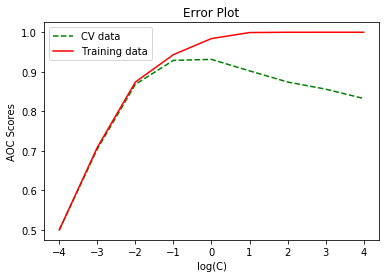

In [12]:
hyperSearch(train_cnt,cv_cnt,y_train,y_cv,"l1")

In [13]:
clf=LogisticRegression(C=1, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_cnt, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

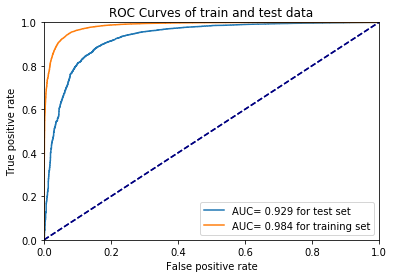

In [14]:
rocPlot(test_cnt, train_cnt, y_train, y_test)

#### Confusion matrix plot for training as well as test data

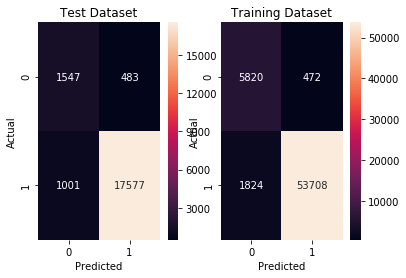

In [15]:
pred=clf.predict(test_cnt)
pred_train=clf.predict(train_cnt)
con_mx(pred, y_test, pred_train, y_train)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [16]:
w=clf.coef_
print(np.count_nonzero(w))  #to get number of non zero terms
train_cnt.shape

4200


(61824, 47108)

##### (47108-4200)/47108= 0.90 i.e., Sparsity of matrix is 91%.

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

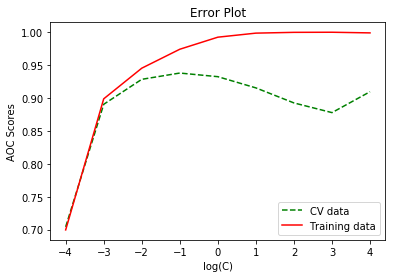

In [22]:
hyperSearch(train_cnt,cv_cnt,y_train,y_cv,"l2")

In [23]:
clf=LogisticRegression(C=0.1, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_cnt, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

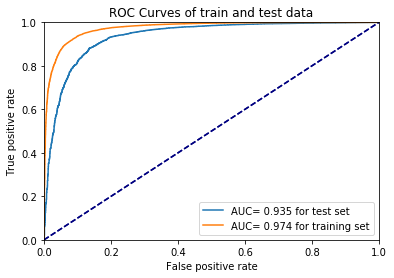

In [24]:
rocPlot(test_cnt, train_cnt, y_train, y_test)

#### Confusion matrix plot for training as well as test data

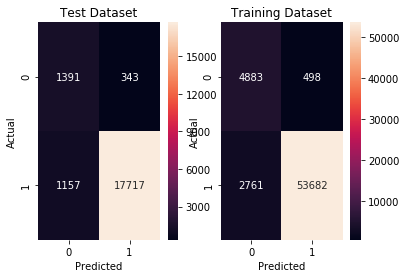

In [25]:
pred=clf.predict(test_cnt)
pred_train=clf.predict(train_cnt)
con_mx(pred, y_test, pred_train, y_train)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [28]:
w=clf.coef_
w+=10**-6
cng_lst=[]
import copy
train_bowp=copy.deepcopy(train_cnt) #to copy all elements from sparse matrix
z=train_bowp.astype('f')           #changing datatype from int64 to float64 for casting compatibility
np.random.seed(42)
e=np.random.normal(0,0.01)         #generating small noise
z.data+=e               #adding noise to sparse matrix
clp=LogisticRegression(C=0.1, penalty='l2', random_state=0)   
clp.fit(z, y_train)      #training LR model on matrix with added noise
wp=clp.coef_
wp+=10**-6              #to avoid divisionbyZero error
#print(wp)
cng=abs(((w-wp)/w)*100)#calculation of change in weight vector of original matrix and matrix with noise added
for i in range(0,100,5):
    cng_lst.append( np.percentile(cng,i))
#cng[0].shape
#cng_lst
#np.percentile(cng,88)

Text(0.5,1,'Plot to find knee value')

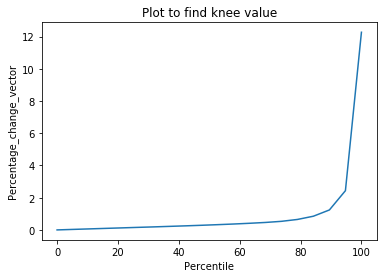

In [29]:
x1=list(np.linspace(0,100,20))
y=cng_lst
plt.plot(x1,y)
plt.xlabel("Percentile")
plt.ylabel("Percentage_change_vector")
plt.title("Plot to find knee value")

From the about plot, we can see that there is sudden rise in percentage change vector around 86th percentile. So, it is safe to say that the value of change vector at 86th percentile is threshold value.

In [31]:
np.percentile(cng,88)

1.775752059689582

In [35]:
lst=cng.tolist()                 
qaz=lst[0]
l=[]
for i in range(len(qaz)):
    if qaz[i]>1.77:
        l.append(i)
count=0
for i in l:
    if(count>30):
        break
    else:
        print(vect.get_feature_names()[i], end=', ')  #printing all features for which change in weight vector is greater than 2.5
    count+=1

aaahhhhhh, aaf, aahs, abbreviated, abbreviation, aberdeen, abi, abid, abigirl, ablution, aboslutely, abouttwinings, abovementioned, abovethirst, abreva, absconding, absentmindedly, absolutelyawful, absorbance, abstaining, abuela, abyssinian, accasion, accentuates, acceptalble, accessorize, accidental, accidents, accredited, accrue, accusatory, 

##### Multicolinearity is to find redundent features, if any. As, multicolinearity increases standard error of coefficients. Given threshold 1.77 for correlation, above code snippet prints all the features which are correlated, i.e., which change in weight vector after adding small noise is varying more than 1.77

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [36]:
coef_l2=clf.coef_[0]
features_10=np.argpartition(coef_l2,-10)[-10:] #only to sort incides of top 10 weights
for i in features_10:
    print(vect.get_feature_names()[i], end=', ')

wonderful, pleased, perfect, loves, awesome, best, highly, excellent, great, delicious, 

#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [37]:
%%time
neg_10=np.argpartition(coef_l2,10)[:10] #indices of top 10 features from negative class
for i in neg_10:
    print(vect.get_feature_names()[i], end=', ')

horrible, worst, disappointment, terrible, disappointing, disappointed, awful, unfortunately, threw, bland, Wall time: 573 ms


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

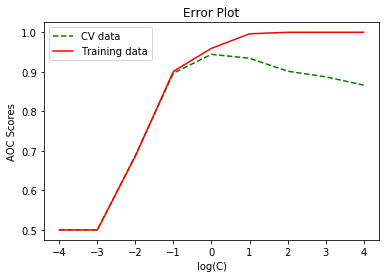

In [38]:
hyperSearch(train_tf,cv_tf,y_train,y_cv,"l1")

In [39]:
clf=LogisticRegression(C=1, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_tf, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

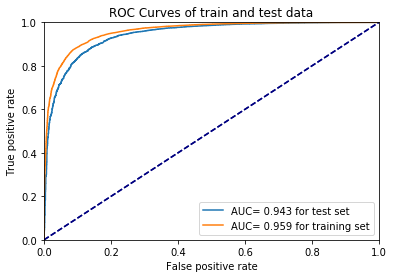

In [40]:
rocPlot(test_tf, train_tf, y_train, y_test)

#### Confusion matrix plot for training as well as test data

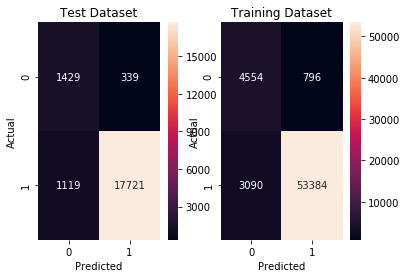

In [41]:
pred=clf.predict(test_tf)
pred_train=clf.predict(train_tf)
con_mx(pred, y_test, pred_train, y_train)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

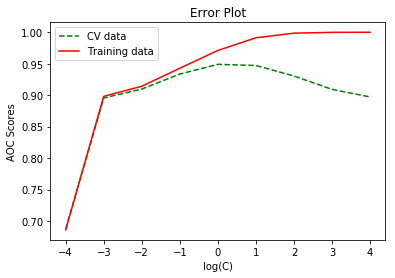

In [42]:
hyperSearch(train_tf,cv_tf,y_train,y_cv,"l2")

In [43]:
clf=LogisticRegression(C=1, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_tf, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

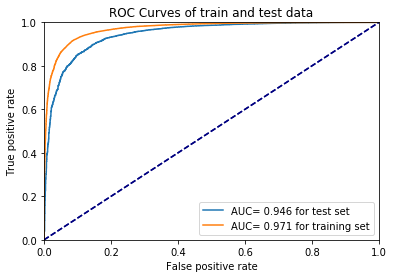

In [44]:
rocPlot(test_tf, train_tf, y_train, y_test)

#### Confusion matrix plot for training as well as test data

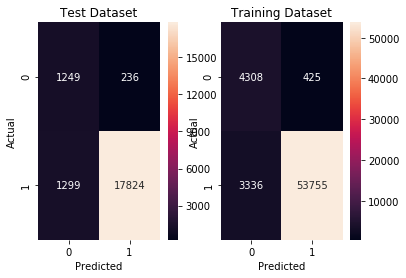

In [45]:
pred=clf.predict(test_tf)
pred_train=clf.predict(train_tf)
con_mx(pred, y_test, pred_train, y_train)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [46]:
coef_l2=clf.coef_[0]
features_10=np.argpartition(coef_l2,-10)[-10:] #only to sort incides oftop 10 weights
for i in features_10:
    print(vect.get_feature_names()[i], end=', ')

highly, wonderful, loves, best, perfect, excellent, love, good, great, delicious, 

#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [47]:
neg_10=np.argpartition(coef_l2,10)[:10] #only to sort incides oftop 10 weights
for i in neg_10:
    print(vect.get_feature_names()[i], end=', ')

disappointing, unfortunately, not, terrible, awful, worst, horrible, disappointment, disappointed, threw, 

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

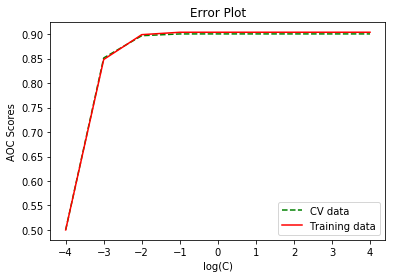

In [48]:
hyperSearch(train_w2v,cv_w2v,y_train,y_cv,"l1")

In [49]:
clf=LogisticRegression(C=0.01, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_w2v, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

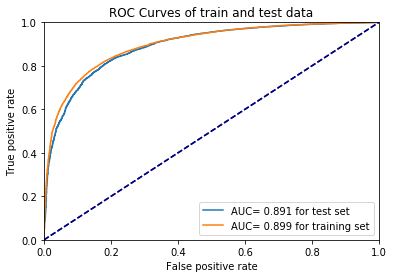

In [50]:
rocPlot(test_w2v, train_w2v, y_train, y_test)

#### Confusion matrix plot for training as well as test data

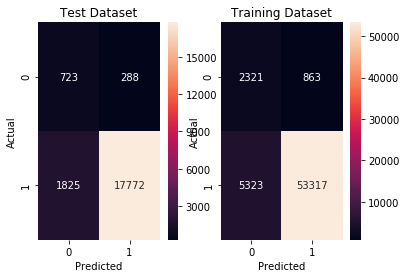

In [51]:
pred=clf.predict(test_w2v)
pred_train=clf.predict(train_w2v)
con_mx(pred, y_test, pred_train, y_train)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

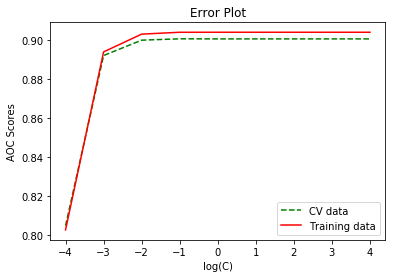

In [52]:
hyperSearch(train_w2v,cv_w2v,y_train,y_cv,"l2")

In [53]:
clf=LogisticRegression(C=0.01, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_w2v, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

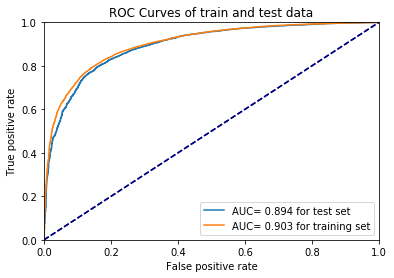

In [54]:
rocPlot(test_w2v, train_w2v, y_train, y_test)

#### Confusion matrix plot for training as well as test data

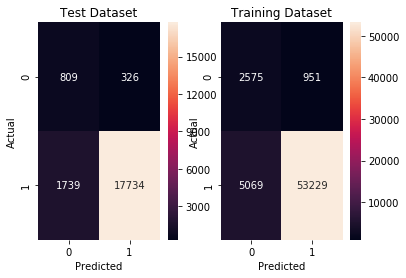

In [55]:
pred=clf.predict(test_w2v)
pred_train=clf.predict(train_w2v)
con_mx(pred, y_test, pred_train, y_train)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

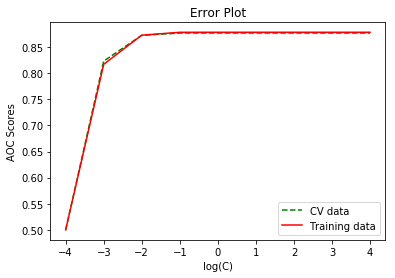

In [56]:
hyperSearch(train_df,cv_df,y_train,y_cv,"l1")

In [57]:
clf=LogisticRegression(C=0.01, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_df, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

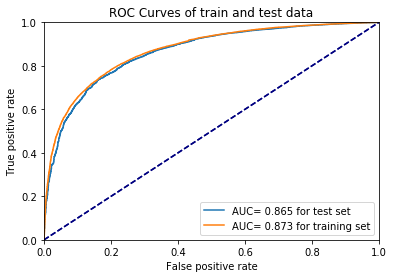

In [58]:
rocPlot(test_df, train_df, y_train, y_test)

#### Confusion matrix plot for training as well as test data

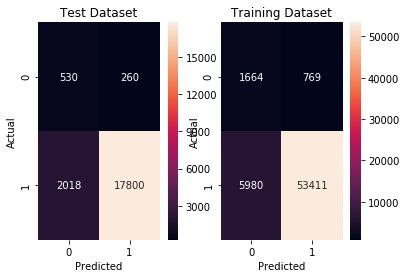

In [59]:
pred=clf.predict(test_df)
pred_train=clf.predict(train_df)
con_mx(pred, y_test, pred_train, y_train)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

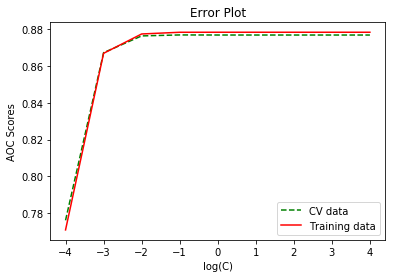

In [60]:
hyperSearch(train_df,cv_df,y_train,y_cv,"l2")

In [61]:
clf=LogisticRegression(C=0.01, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_df, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

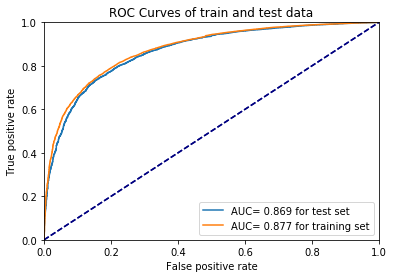

In [62]:
rocPlot(test_df, train_df, y_train, y_test)

#### Confusion matrix plot for training as well as test data

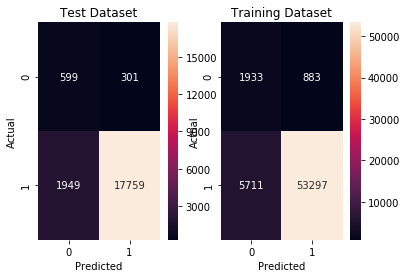

In [63]:
pred=clf.predict(test_df)
pred_train=clf.predict(train_df)
con_mx(pred, y_test, pred_train, y_train)

# [5.5] Feature Engineering

#### Merging summary text along with review text, followed by vectorizing text in BOW, TFIDF, AVG W2V & TFIDF W2V

In [64]:
df['demo']=df['CleanedText']+df['Summary']
textr=df['demo']
labelr=df['Score']
x,x_testf,y,y_testf=train_test_split(textr,labelr,test_size=0.2,random_state=0, stratify=labelr)
x_trainf,x_cvf,y_trainf,y_cvf=train_test_split(x,y,test_size=0.25, random_state=0, stratify=y)
vectt=CountVectorizer().fit(x_trainf)
train_r=vectt.transform(x_trainf)
cv_r=vectt.transform(x_cvf)
test_r=vectt.transform(x_testf)
tf=TfidfVectorizer().fit(x_trainf)
train_f=tf.transform(x_trainf)
cv_f=tf.transform(x_cvf)
test_f=tf.transform(x_testf)

In [65]:
list_of_words_fe=[]
for x in x_trainf.values:
    list_of_words_fe.append(x.split())
    
w2v_model=Word2Vec(list_of_words_fe, min_count=5, size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

    
test_word_list_fe=[]
for x in x_testf.values:
    test_word_list_fe.append(x.split())
    
cv_word_list_fe=[]
for x in x_cvf.values:
    cv_word_list_fe.append(x.split())
    
train_w2v_fe=[];
for x in tqdm(list_of_words_fe):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    train_w2v_fe.append(sent_vec)
    
    
cv_w2v_fe=[];
for x in tqdm(cv_word_list_fe):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_w2v_fe.append(sent_vec)

test_w2v_fe=[]
for x in tqdm(test_word_list_fe):
    sent_vec=np.zeros(50)
    cnt_words=0
    for y in x:
        if y in w2v_words:
            vec=w2v_model.wv[y]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words != 0:
        sent_vec /= cnt_words
    test_w2v_fe.append(sent_vec)
    

100%|███████████████████████████████████| 20608/20608 [00:59<00:00, 345.57it/s]


In [66]:
model = TfidfVectorizer()
model.fit_transform(x_trainf.values)

dicti= dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 

train_df_fe= [];
row=0;
for sent in tqdm(list_of_words_fe): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            
    
            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    train_df_fe.append(sent_vec)
    row += 1
    
tfidf_feat = model.get_feature_names() 

test_df_fe= []; 
row=0;
for sent in tqdm(test_word_list_fe):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    test_df_fe.append(sent_vec)
    row += 1
    
    
cv_d_fef= []; 
row=0;
for sent in tqdm(cv_word_list_fe):
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]

            tf_idf = dicti[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_d_fef.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 20608/20608 [29:13<00:00, 14.52it/s]


## [5.6.1] Logistic Regression on BOW

### [5.6.1.1] Applying Logistic Regression with L1 regularization on BOW

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

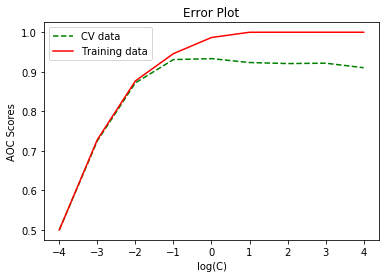

In [92]:
hyperSearch(train_r,cv_r,y_trainf,y_cvf,"l1")

In [67]:
clf=LogisticRegression(C=1, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_r, y_trainf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

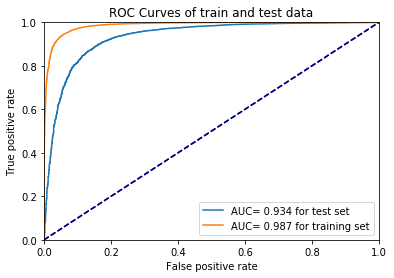

In [68]:
rocPlot(test_r, train_r, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

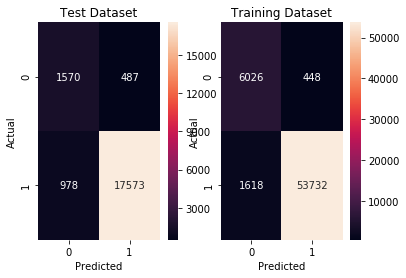

In [69]:
pred=clf.predict(test_r)
pred_train=clf.predict(train_r)
con_mx(pred, y_testf, pred_train, y_trainf)

### [5.6.1.1] Applying Logistic Regression with L2 regularization on BOW

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

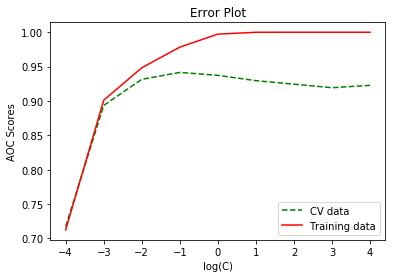

In [80]:
hyperSearch(train_r,cv_r,y_trainf,y_cvf,"l2")

In [81]:
clf=LogisticRegression(C=0.01, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_r, y_trainf)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

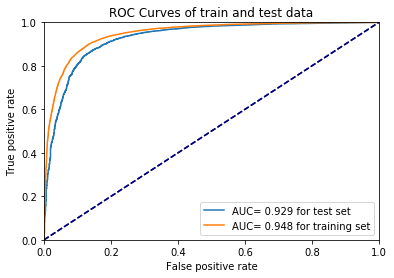

In [82]:
rocPlot(test_r, train_r, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

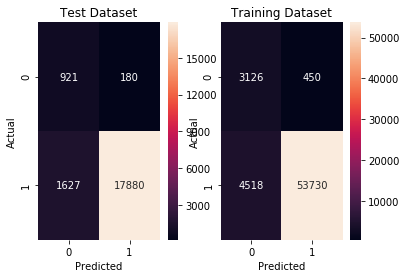

In [83]:
pred=clf.predict(test_r)
pred_train=clf.predict(train_r)
con_mx(pred, y_testf, pred_train, y_trainf)

## [5.6.2] Logistic Regression on TFIDF

### [5.6.2.1] Applying Logistic Regression with L1 regularization on TFIDF

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

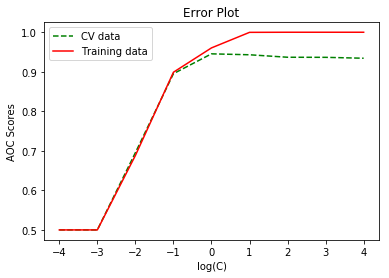

In [84]:
hyperSearch(train_f,cv_f,y_trainf,y_cvf,"l1")

In [85]:
clf=LogisticRegression(C=1, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_f, y_trainf)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

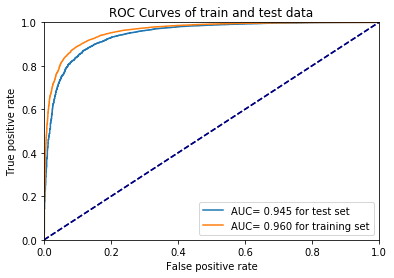

In [86]:
rocPlot(test_f, train_f, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

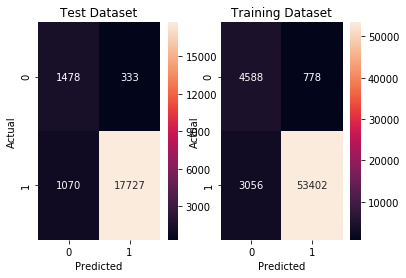

In [87]:
pred=clf.predict(test_f)
pred_train=clf.predict(train_f)
con_mx(pred, y_testf, pred_train, y_trainf)

### [5.6.2.1] Applying Logistic Regression with L2 regularization on TFIDF

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

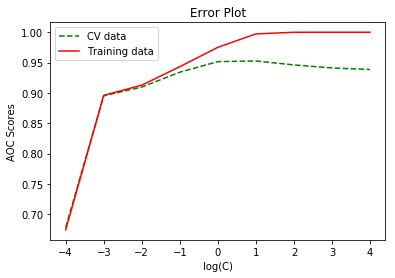

In [88]:
hyperSearch(train_f,cv_f,y_trainf,y_cvf,"l2")

In [89]:
clf=LogisticRegression(C=10, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_f, y_trainf)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

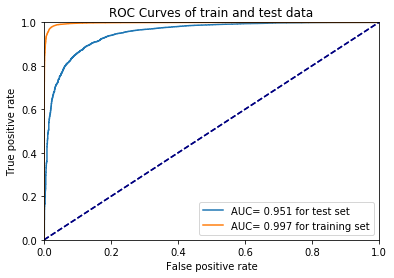

In [90]:
rocPlot(test_f, train_f, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

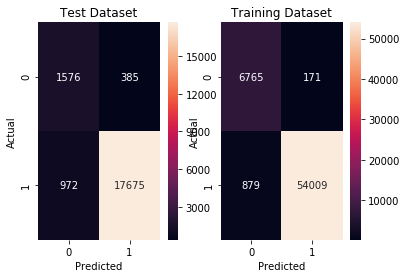

In [91]:
pred=clf.predict(test_f)
pred_train=clf.predict(train_f)
con_mx(pred, y_testf, pred_train, y_trainf)

## [5.6.3] Logistic Regression on AVG W2V

### [5.6.3.1] Applying Logistic Regression with L1 regularization on AVG W2V

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

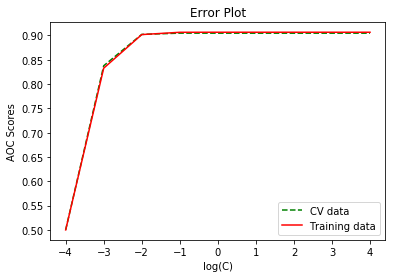

In [76]:
hyperSearch(train_w2v_fe,cv_w2v_fe,y_trainf,y_cvf,"l1")

In [77]:
clf=LogisticRegression(C=0.01, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_w2v_fe, y_trainf)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

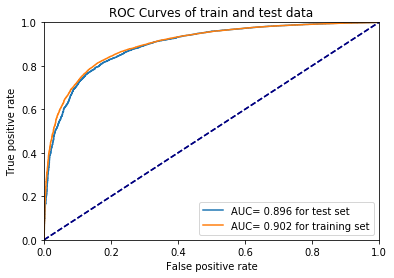

In [78]:
rocPlot(test_w2v_fe, train_w2v_fe, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

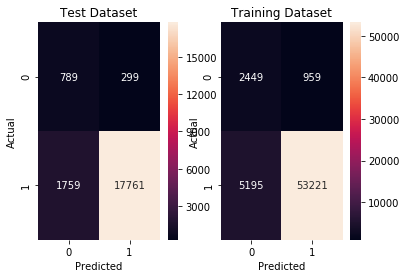

In [79]:
pred=clf.predict(test_w2v_fe)
pred_train=clf.predict(train_w2v_fe)
con_mx(pred, y_testf, pred_train, y_trainf)

### [5.6.3.2] Applying Logistic Regression with L2 regularization on AVG W2V

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

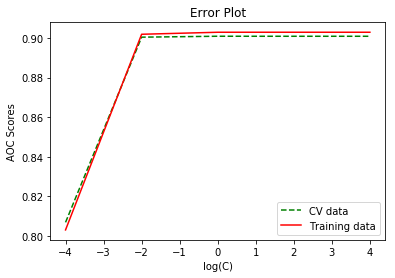

In [78]:
hyperSearch(train_w2v_fe,cv_w2v_fe,y_trainf,y_cvf,"l2")

In [79]:
clf=LogisticRegression(C=0.01, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_w2v_fe, y_trainf)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

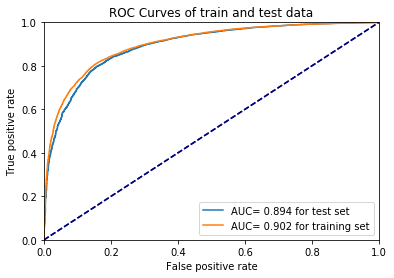

In [80]:
rocPlot(test_w2v_fe, train_w2v_fe, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

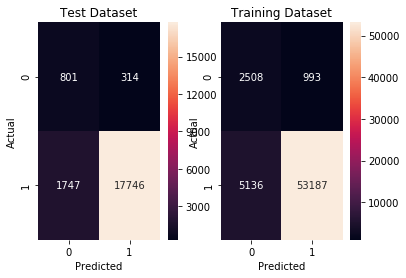

In [81]:
pred=clf.predict(test_w2v_fe)
pred_train=clf.predict(train_w2v_fe)
con_mx(pred, y_testf, pred_train, y_trainf)

## [5.6.4] Logistic Regression on TFIDF W2V

### [5.6.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

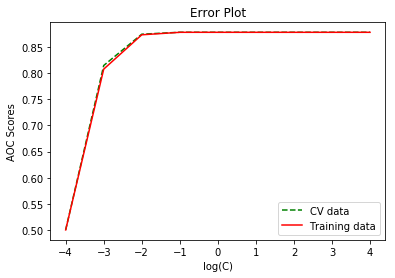

In [68]:
hyperSearch(train_df_fe,cv_d_fef,y_trainf,y_cvf,"l1")

In [69]:
clf=LogisticRegression(C=0.01, penalty='l1', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_df_fe, y_trainf)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

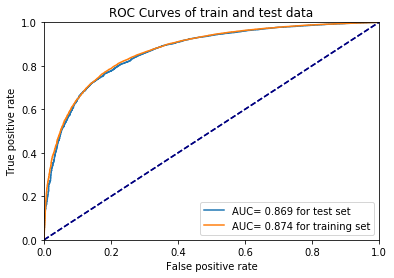

In [70]:
rocPlot(test_df_fe, train_df_fe, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

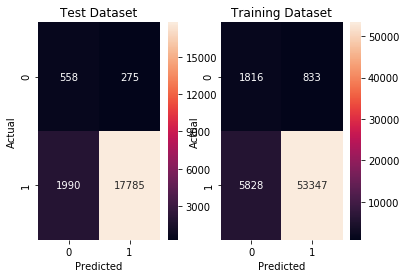

In [71]:
pred=clf.predict(test_df_fe)
pred_train=clf.predict(train_df_fe)
con_mx(pred, y_testf, pred_train, y_trainf)

### [5.6.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V

#### Plot of AUC vs log(C) to find optimal value of hyperparameter C

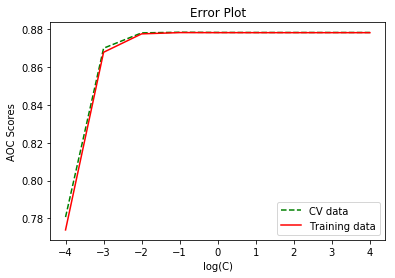

In [72]:
hyperSearch(train_df_fe,cv_d_fef,y_trainf,y_cvf,"l2")

In [73]:
clf=LogisticRegression(C=0.01, penalty='l2', random_state=0) #fitting LR on test data with optimal value of hyperparameter C
clf.fit(train_df_fe, y_trainf)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### ROC Curve for training and test dataset

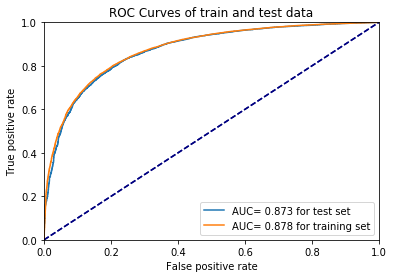

In [74]:
rocPlot(test_df_fe, train_df_fe, y_trainf, y_testf)

#### Confusion matrix plot for training as well as test data

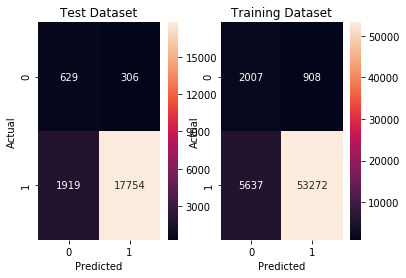

In [75]:
pred=clf.predict(test_df_fe)
pred_train=clf.predict(train_df_fe)
con_mx(pred, y_testf, pred_train, y_trainf)

# [6] Conclusions

In [17]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=["Vectorizer", "Regularizer", "Hyper Parameter", "AUC"]
x.add_row(["BOW", "l1", 1, 0.929])
x.add_row(["BOW", "l2", 1, 0.935])
x.add_row(["TF-IDF","l1", 1, 0.943])
x.add_row(["TF-IDF","l2", 1, 0.946])
x.add_row(["AVG W2V","l1", 0.01, 0.891])
x.add_row(["AVG W2V","l2", 0.01, 0.895])
x.add_row(["TFIDF W2V","l1", 0.01, 0.865])
x.add_row(["TFIDF W2V","l2", 0.01, 0.873])
x.add_row(["BOW(Feature engg)", "l1", 1, 0.934])
x.add_row(["BOW(feature engg)", "l2", 1, 0.936])
x.add_row(["TF-IDF(feature engg)","l1", 1, 0.945])
x.add_row(["TF-IDF(feature engg)","l2", 1, 0.951])
x.add_row(["AVG W2V(feature engg)","l1", 0.01, 0.896])
x.add_row(["AVG W2V(feature engg)","l2", 0.01, 0.894])
x.add_row(["TFIDF W2V(feature engg)","l1", 0.01, 0.869])
x.add_row(["TFIDF W2V(feature engg)","l2", 0.01, 0.873])
print(x)

+-------------------------+-------------+-----------------+-------+
|        Vectorizer       | Regularizer | Hyper Parameter |  AUC  |
+-------------------------+-------------+-----------------+-------+
|           BOW           |      l1     |        1        | 0.929 |
|           BOW           |      l2     |        1        | 0.935 |
|          TF-IDF         |      l1     |        1        | 0.943 |
|          TF-IDF         |      l2     |        1        | 0.946 |
|         AVG W2V         |      l1     |       0.01      | 0.891 |
|         AVG W2V         |      l2     |       0.01      | 0.895 |
|        TFIDF W2V        |      l1     |       0.01      | 0.865 |
|        TFIDF W2V        |      l2     |       0.01      | 0.873 |
|    BOW(Feature engg)    |      l1     |        1        | 0.934 |
|    BOW(feature engg)    |      l2     |        1        | 0.936 |
|   TF-IDF(feature engg)  |      l1     |        1        | 0.945 |
|   TF-IDF(feature engg)  |      l2     |       

Linear regression is performed on all four vectorizers with both type of regularization l1 & l2.
Since, L1 reg eliminates the weight of least imp feature by making them zero and thus output in sparse matrix.

Pertubation test is performes on BOW((L2 Reg) to get the correlated features and further, top 10 features from both classes has retrived based on weight of coefficients. 

Feature engg is performed by merging the summary with review text and has performed all the steps. There is slight increment of AUC of BOW & TFIDF after that. But AVG w2v & TFIDF W2V seems almost unaffected.